## **Домашняя работа №1**

Нужно самостоятельно реализовать колоборативную фильтрацию методами:

1. Knn нужно реализовать 2 базовых метода
    1. Простой KNN (в библиотеке surprise называется KNNBasic)
    2. Непараметрическая регрессия Надарайя-Ватсона (в библиотеке surprise называется KNNWithMeans)
2. SVD-разложение
    1. Метод SGD
    2. Метод ALS
3. SVD++

С полученными методами нужно произвести следующие исследования:

*   Нужно сравнить время работы всех реализованных алгоритмов.
*   Нужно сравнить точность (в смысле RMSE) всех реализованных алгоритмов.
    *   Качество (в смысле RMSE) kNN по параметру k
    *   Качество (в смысле RMSE) SVD по числу факторов
    *   Качество (в смысле RMSE) SVD по числу итераций в SGD

В качестве датасэта можно использовать, например, https://grouplens.org/datasets/movielens/ (можно любой другой).

Можно вдохновляться библиотеками (но не копировать код):
https://implicit.readthedocs.io/en/latest/quickstart.html
https://surprise.readthedocs.io/en/stable/getting_started.html

## **Подготовка данных**

In [1]:
import pandas as pd
import numpy as np
import scipy
from time import time
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from numba import njit

import warnings

In [2]:
# Read data.
path = 'ml-25m'

df = pd.read_csv(f'{path}/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
top_users = df['userId'].value_counts()[:100_000]
top_movies = df['movieId'].value_counts()[:100_000]

Для упрощения вычислительной сложности и наглядности берем только наиболее популярные фильмы и юзеров. 

In [4]:
df = df[df['userId'].isin(top_users) & df['movieId'].isin(top_movies)]

Для удобства перенумеруем id 

In [5]:
user_map = {value: new_value for new_value, value in enumerate(df['userId'].unique())}
movie_map = {value: new_value for new_value, value in enumerate(df['movieId'].unique())}

df['userId'] = df['userId'].map(user_map)
df['movieId'] = df['movieId'].map(movie_map)

In [6]:
df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

In [7]:
def pivoter(data, user_column, item_column, rating_column, none_value):
    # Pivots the data
    return (
        data.pivot(
            index=user_column,
            columns=item_column,
            values=rating_column
        ).fillna(none_value)
    )

In [8]:
def train_test_pivoter(
        df, test_size, 
        user_column, item_column, rating_column, 
        none_value
    ):

    train_df, test_df = train_test_split(df, test_size=test_size)

    # add items from train to test and vice versa
    # so that they have same shape matrices 
    train_df = pd.concat([
        train_df,
        test_df.assign(**{rating_column: none_value})
    ]).drop_duplicates(subset=[user_column, item_column])

    
    train = pivoter(train_df, user_column, item_column, rating_column, none_value).to_numpy()
    
    train_df.dropna(inplace=True)
    train_df.set_index(np.arange(len(train_df)), inplace=True)

    return train_df, train, test_df

In [9]:
train_df, train, test_df = train_test_pivoter(
    df, 0.33,
    'userId', 'movieId', 'rating', 
    np.nan
)

`train` - матрица со значениями 
пропуски заполнены именно `nan` 

`test_df` - датафрейм с парами юзер, фильм для которых надо предсказать значение.

## **Простой KNN**

В расстоянии нужно учитывать `nan`  
Поэтому для L2 расстояния берется среднее отклонение по всем не пустым координатам  

In [10]:
@njit(parallel=True)
def my_euclidean(x, y):
    ids = ~np.isnan(x) & ~np.isnan(y)
    
    if np.sum(ids) == 0:
        return np.nan
    
    return np.sum((x[ids] - y[ids])**2) / np.sum(ids)

@njit(parallel=True)
def my_cosine(x, y):
    ids = ~np.isnan(x) & ~np.isnan(y)
    
    if np.sum(ids) == 0:
        return np.nan
    
    return (x[ids] @ y[ids]) / (np.linalg.norm(x[ids]) * np.linalg.norm(y[ids])) 

In [68]:
class KNN:
    def __init__(self, k, based='user', metric='euclidean'):
        
        if based not in ('user', 'item'):
            raise ValueError('Wrong based system')

        self.k = k
        self.based = based
        self.metric = metric

    def fit(self, train):
        
        if self.based == 'user':
            pass

        if self.based == 'item':
            train = train.T

        self.distances = pairwise_distances(
            train, train, 
            force_all_finite='allow-nan', 
            metric=my_euclidean
        )
        self.neighbours = self.distances.argsort(axis=1)
        self.train = train

    def predict(self, test_data):
        predictions = []
        mean = np.nanmean(train)

        if self.based == 'user':
            iterator = test_data[['userId', 'movieId']].iterrows()

        if self.based == 'item':
            iterator = test_data[['movieId', 'userId']].iterrows()

        for _, (user_id, item_id) in iterator:
            watched = ~np.isnan(self.train[:, item_id])
            watched = np.arange(len(watched))[watched]
            watched = self.neighbours[user_id][np.isin(self.neighbours[user_id], watched)]
            watched = watched[:self.k]

            if np.sum(watched) == 0:
                pred = mean
            else:
                pred = np.nanmean(self.train[watched][:, item_id])

            predictions.append(pred)

        return predictions

In [12]:
test_df['train_mean'] = train_df['rating'].mean()
MAE = (test_df['train_mean'] - test_df['rating']).abs().mean()
print(f'MAE of baseline {MAE:.2f}')

MAE of baseline 0.86


In [13]:
model = KNN(k=10)

model.fit(train)
preds = model.predict(test_df)

In [14]:
test_df['knn_preds'] = preds
MAE = (test_df['knn_preds'] - test_df['rating']).abs().mean()
print(f'MAE of knn {MAE:.2f}')

MAE of knn 0.73


## **Непараметрическая регрессия Надарайя-Ватсона**

In [65]:
class KNN_NW:
    def __init__(self, k, based='user', metric='euclidean'):
        
        if based not in ('user', 'item'):
            raise ValueError('Wrong based system')

        self.k = k
        self.based = based
        self.metric = metric

    def fit(self, train):        
        if self.based == 'user':
            pass

        if self.based == 'item':
            train = train.T

        self.distances = pairwise_distances(
            train, train, 
            force_all_finite='allow-nan', 
            metric=my_euclidean
        )
        self.neighbours = self.distances.argsort(axis=1)
        self.train = train

    def predict(self, test_data):
        predictions = []
        total_mean = np.nanmean(train)

        if self.based == 'user':
            iterator = test_data[['userId', 'movieId']].iterrows()

        if self.based == 'item':
            iterator = test_data[['movieId', 'userId']].iterrows()

        for _, (user_id, item_id) in iterator:
            watched = ~np.isnan(self.train[:, item_id])
            watched = np.arange(len(watched))[watched]
            watched = self.neighbours[user_id][np.isin(self.neighbours[user_id], watched)]
            watched = watched[:self.k]

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                
                mean = np.nanmean(self.train[user_id])
                num = np.nansum(self.distances[user_id, watched] * (train[watched, item_id] - mean))
                den = np.nansum(self.distances[user_id, watched])

            if np.isnan(mean):
                mean = total_mean

            if np.abs(den) > 1e-5:
                pred = mean + num / den
            else:
                pred = mean

            predictions.append(pred)

        return predictions

In [16]:
model = KNN_NW(k=10)

model.fit(train)
preds = model.predict(test_df)

In [17]:
test_df['knn_nw_preds'] = preds
MAE = (test_df['knn_nw_preds'] - test_df['rating']).abs().mean()
print(f'MAE of knn_nw {MAE:.2f}')

MAE of knn_nw 0.80


## **SVD разложение методами: SGD, ALS**

In [18]:
class SVD:
    def __init__(self, emb_size, n_users, n_items):

        self.emb_size = emb_size
        self.b_user = np.random.normal(size=n_users)
        self.b_item = np.random.normal(size=n_items)

        self.Q = np.random.normal(size=(n_users, emb_size))
        self.P = np.random.normal(size=(n_items, emb_size))

    
    def train_sgd(self, train_df, lr, n_epochs, reg_lambda):
        
        self.mean = train_df['rating'].mean()

        for _ in range(n_epochs):
            iterator = train_df[['userId', 'movieId', 'rating']].itertuples()
            for _, user_id, item_id, rating in iterator:
                pred = (
                    self.mean + 
                    self.b_user[user_id] + self.b_item[item_id] +
                    self.Q[user_id] @ self.P[item_id]
                ) 

                err = rating - pred
                
                self.b_user[user_id] += lr * (err - reg_lambda * self.b_user[user_id])
                self.b_item[item_id] += lr * (err - reg_lambda * self.b_item[item_id])

                self.Q[user_id] += lr * (err * self.P[item_id] - reg_lambda * self.Q[user_id])
                self.P[item_id] += lr * (err * self.Q[user_id] - reg_lambda * self.P[item_id])

    def train_als(self, train, n_epochs, alpha):
        
        self.mean = np.nanmean(train)

        reg_ones = alpha * np.eye(self.emb_size + 1)

        for _ in range(n_epochs):
            for user_id in range(train.shape[0]):
                ids = ~np.isnan(train[user_id])

                ratings = train[user_id, ids]
                movie_emb = self.P[ids]

                # Add column of ones
                n_watched = len(movie_emb)
                movie_emb = np.hstack([movie_emb, np.ones((n_watched, 1))])
        
                sol = np.linalg.inv(movie_emb.T @ movie_emb + reg_ones) @ movie_emb.T @ (ratings - self.mean)
                self.Q[user_id] = sol[:-1].copy()
                self.b_user[user_id] = sol[-1]

            for item_id in range(train.shape[1]):
                ids = ~np.isnan(train[:, item_id])

                ratings = train[ids, item_id]
                user_emb = self.Q[ids]

                # Add column of ones
                n_watched = len(user_emb)
                user_emb = np.hstack([user_emb, np.ones((n_watched, 1))])

                sol = np.linalg.inv(user_emb.T @ user_emb + reg_ones) @ user_emb.T @ (ratings - self.mean)
                self.P[item_id] = sol[:-1].copy()
                self.b_item[item_id] = sol[-1]

    def predict(self, test_df):
        
        preds = []
        for _, user_id, item_id in test_df[['userId', 'movieId']].itertuples():
            preds.append(
                self.mean + 
                self.b_user[user_id] + self.b_item[item_id] + 
                self.Q[user_id] @ self.P[item_id]
            )
        
        return preds
    

In [19]:
model = SVD(emb_size=20, n_users=train.shape[0], n_items=train.shape[1])
model.train_sgd(train_df, lr=0.01, n_epochs=50, reg_lambda=0.1)
preds = model.predict(test_df)

In [20]:
test_df['svd_sgd'] = preds
MAE = (test_df['svd_sgd'] - test_df['rating']).abs().mean()
print(f'MAE of svd_sgd {MAE:.2f}')

MAE of svd_sgd 0.71


In [21]:
model = SVD(emb_size=20, n_users=train.shape[0], n_items=train.shape[1])
model.train_als(train, n_epochs=10, alpha=1)
preds = model.predict(test_df)

In [22]:
test_df['svd_als'] = preds
MAE = (test_df['svd_als'] - test_df['rating']).abs().mean()
print(f'MAE of svd_als {MAE:.2f}')

MAE of svd_als 0.86


## **SVD++**

In [23]:
class SVDPlus:
    def __init__(self, emb_size, n_users, n_items):

        self.emb_size = emb_size
        self.b_user = np.random.normal(size=n_users)
        self.b_item = np.random.normal(size=n_items)
        self.y = np.random.normal(size=n_items)

        self.Q = np.random.normal(size=(n_users, emb_size))
        self.P = np.random.normal(size=(n_items, emb_size))

    
    def train_sgd(self, train_df, train, lr, n_epochs, reg_lambda):
        
        self.mean = train_df['rating'].mean()

        for _ in range(n_epochs):
            iterator = train_df[['userId', 'movieId', 'rating']].itertuples()
            for _, user_id, item_id, rating in iterator:
                
                ids = ~np.isnan(train[user_id])

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    sum_y_i = np.nansum(self.y[ids])
                            
                var_control = np.sqrt(np.sum(ids)) if sum_y_i != 0 else 1

                pred = (
                    self.mean + 
                    self.b_user[user_id] + self.b_item[item_id] +
                    self.Q[user_id] @ (self.P[item_id] + sum_y_i / var_control)
                ) 

                err = rating - pred
                
                self.b_user[user_id] += lr * (err - reg_lambda * self.b_user[user_id])
                self.b_item[item_id] += lr * (err - reg_lambda * self.b_item[item_id])

                self.Q[user_id] += lr * (err * self.P[item_id] - reg_lambda * self.Q[user_id])
                self.P[item_id] += lr * (err * self.Q[user_id] - reg_lambda * self.P[item_id])

                self.y[ids] += lr * (err * np.sum(self.Q[user_id]) / var_control - reg_lambda * self.y[ids])


    def predict(self, test_df):
        
        preds = []
        for _, user_id, item_id in test_df[['userId', 'movieId']].itertuples():
            preds.append(
                self.mean + 
                self.b_user[user_id] + self.b_item[item_id] + 
                self.Q[user_id] @ self.P[item_id]
            )
        
        return preds
    

In [24]:
model = SVDPlus(emb_size=20, n_users=train.shape[0], n_items=train.shape[1])
model.train_sgd(train_df, train, lr=0.005, n_epochs=10, reg_lambda=10)
preds = model.predict(test_df)

In [25]:
test_df['svd_plus'] = preds
MAE = (test_df['svd_plus'] - test_df['rating']).abs().mean()
print(f'MAE of svd_plus {MAE:.2f}')

MAE of svd_plus 0.83


# Test time

In [26]:
from time import time, sleep

In [29]:
time_measure = {}

In [30]:
start = time()

model = KNN(k=10)
model.fit(train)
preds = model.predict(test_df)

end = time()

time_measure['KNN'] = end - start

In [31]:
start = time()

model = KNN_NW(k=10)
model.fit(train)
preds = model.predict(test_df)

end = time()

time_measure['KNN_NW'] = end - start

In [32]:
start = time()

model = SVD(emb_size=20, n_users=train.shape[0], n_items=train.shape[1])
model.train_sgd(train_df, lr=0.01, n_epochs=50, reg_lambda=0.1)
preds = model.predict(test_df)

end = time()

time_measure['SVD_SGD'] = end - start

In [33]:
start = time()

model = SVD(emb_size=20, n_users=train.shape[0], n_items=train.shape[1])
model.train_als(train, n_epochs=10, alpha=1)
preds = model.predict(test_df)

end = time()
time_measure['SVD_ALS'] = end - start

In [34]:
start = time()

model = SVDPlus(emb_size=20, n_users=train.shape[0], n_items=train.shape[1])
model.train_sgd(train_df, train, lr=0.005, n_epochs=10, reg_lambda=10)
preds = model.predict(test_df)

end = time()
time_measure['SVD_PLUS'] = end - start

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
stats_df = pd.DataFrame(time_measure.items(), columns=['name', 'time'])

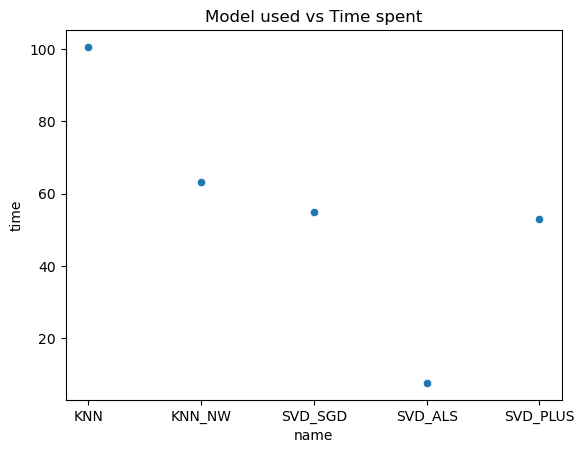

In [49]:
plt.title('Model used vs Time spent')
sns.scatterplot(stats_df, x='name', y='time')
plt.show()

# Test KNN

In [94]:
rmse_stats = {}
model = KNN(k=1)
model.fit(train)

In [97]:
for k in [1, 3, 5, 10, 15, 25, 50]:
    model.k = k
    preds = model.predict(test_df)

    rmse_stats[k] = np.sqrt(np.mean(
        (preds - test_df['rating'])**2
    ))


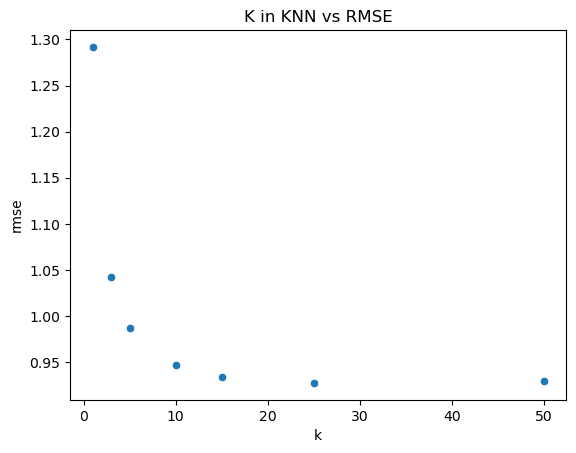

In [100]:
stats_df = pd.DataFrame(rmse_stats.items(), columns=['k', 'rmse'])

plt.title('K in KNN vs RMSE')
sns.scatterplot(stats_df, x='k', y='rmse')
plt.show()

# Test SVD

In [105]:
for emb_size in [1, 10, 50, 150, 300]:
    print(emb_size)
    model = SVD(emb_size, train.shape[0], train.shape[1])
    model.train_als(train, 20, 0.1)
    preds = model.predict(test_df)

    rmse_stats[emb_size] = np.sqrt(np.mean(
        (preds - test_df['rating'])**2
    ))


1
10
50
150
300


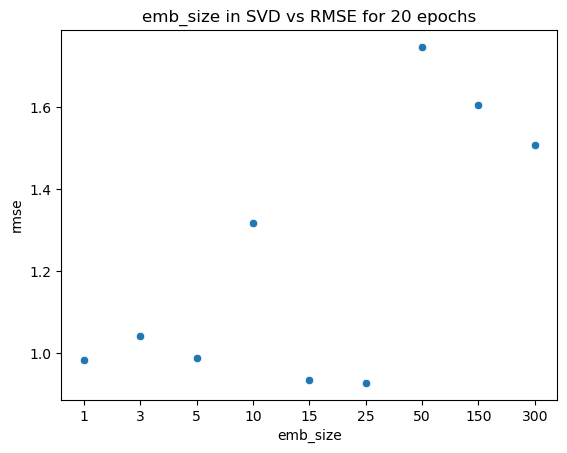

In [109]:
stats_df = pd.DataFrame(rmse_stats.items(), columns=['emb_size', 'rmse'])
stats_df['emb_size'] = stats_df['emb_size'].astype(str)
plt.title('emb_size in SVD vs RMSE for 20 epochs')
sns.scatterplot(stats_df, x='emb_size', y='rmse')
plt.show()